# Import Library

In [2]:
!pip install emoji
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import emoji
import string
from bs4 import BeautifulSoup
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    pipeline, Trainer, TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from datasets import Dataset
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load Dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Interview/makan_bergizi_example_1.csv')
df

NameError: name 'pd' is not defined

# Preprocessing

In [ ]:
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def clean_text(text):
  text = str(text).lower()
  # text = BeautifulSoup(text, "html.parser").get_text()
  text = re.sub(r"http\S+|www.\S+", "", text)
  text = re.sub(r"@\w+|#\w+", "", text)
  text = emoji.replace_emoji(text, "")
  text = re.sub(r"[^\x00-\x7F]+", "", text)
  text = re.sub(r"\d+", "", text)
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = re.sub(r'\s+', ' ', text).strip()
  text = stopword_remover.remove(text)
  text = stemmer.stem(text)
  return text

In [ ]:
df = df[['full_text']]
df

,full_text
0,Kapolda Riau Irjen Pol Herry Heryawan meninjau...
1,Program Makan Bergizi Gratis hadir untuk memas...
2,Kawal Distribusi MBG di Kecamatan Nangaroro Po...
3,Polemik program Makan Bergizi Gratis (MBG) men...
4,Kebumen Jadi Lokasi Pilot Project Dapur Makan ...
...,...
2884,Babinsa Koramil Tungkal Ilir Salurkan Ribuan P...
2885,Babinsa Koramil 419-03/Tungkal Ilir Koptu Firm...
2886,Suku Dinas Perindustrian Perdagangan Koperasi ...
2887,Program MBG atau Makan Bergizi Gratis langkah ...


In [ ]:
df['clean_text'] = df['full_text'].apply(clean_text)
df[['full_text','clean_text']]

/tmp/ipython-input-3619425704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['full_text'].apply(clean_text)


,full_text,clean_text
0,Kapolda Riau Irjen Pol Herry Heryawan meninjau...,kapolda riau irjen pol herry heryawan tinjau l...
1,Program Makan Bergizi Gratis hadir untuk memas...,program makan gizi gratis hadir pasti anak usi...
2,Kawal Distribusi MBG di Kecamatan Nangaroro Po...,kawal distribusi mbg camat nangaroro polres na...
3,Polemik program Makan Bergizi Gratis (MBG) men...,polemik program makan gizi gratis mbg cuat nya...
4,Kebumen Jadi Lokasi Pilot Project Dapur Makan ...,kebumen jadi lokasi pilot project dapur makan ...
...,...,...
2884,Babinsa Koramil Tungkal Ilir Salurkan Ribuan P...,babinsa koramil tungkal ilir salur ribu paket ...
2885,Babinsa Koramil 419-03/Tungkal Ilir Koptu Firm...,babinsa koramil tungkal ilir koptu firmansyah ...
2886,Suku Dinas Perindustrian Perdagangan Koperasi ...,suku dinas industri dagang koperasi usaha keci...
2887,Program MBG atau Makan Bergizi Gratis langkah ...,program mbg makan gizi gratis langkah awal tin...


In [ ]:
df.drop_duplicates(subset='clean_text', inplace=True)
df.count()

/tmp/ipython-input-382395954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='clean_text', inplace=True)


,0
full_text,2401
clean_text,2401


In [ ]:
df.dropna(subset='clean_text', inplace=True)
df.count()

/tmp/ipython-input-2747309781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset='clean_text', inplace=True)


,0
full_text,2401
clean_text,2401


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Interview/Data_MBG_Clean_2.csv', index=False)

# AutoLabeling

In [ ]:
df_cleaned = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Interview/Data_MBG_Clean_2.csv')
df_cleaned

,full_text,clean_text
0,Kapolda Riau Irjen Pol Herry Heryawan meninjau...,kapolda riau irjen pol herry heryawan tinjau l...
1,Program Makan Bergizi Gratis hadir untuk memas...,program makan gizi gratis hadir pasti anak usi...
2,Kawal Distribusi MBG di Kecamatan Nangaroro Po...,kawal distribusi mbg camat nangaroro polres na...
3,Polemik program Makan Bergizi Gratis (MBG) men...,polemik program makan gizi gratis mbg cuat nya...
4,Kebumen Jadi Lokasi Pilot Project Dapur Makan ...,kebumen jadi lokasi pilot project dapur makan ...
...,...,...
2396,Sejumlah menteri kabinet merah putih menghadir...,jumlah menteri kabinet merah putih hadir rapat...
2397,Polsek Ngariboyo Polres Magetan melaksanakan ...,polsek ngariboyo polres magetan laksana kece s...
2398,Babinsa Koramil Tungkal Ilir Salurkan Ribuan P...,babinsa koramil tungkal ilir salur ribu paket ...
2399,Babinsa Koramil 419-03/Tungkal Ilir Koptu Firm...,babinsa koramil tungkal ilir koptu firmansyah ...


### mdhugol

In [ ]:
model_name = "mdhugol/indonesia-bert-sentiment-classification"
model_tokenizer = AutoTokenizer.from_pretrained(model_name)
model_label = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model_label, tokenizer=model_tokenizer)

# Mapping label pipeline ke label sentimen
label_mapping = {
    'label_0': 'positif',
    'label_1': 'netral',
    'label_2': 'negatif'
}

def label_text(text):
    try:
        raw_label = classifier(text)[0]['label'].lower()  # hasil bisa berupa 'label_0', dsb
        return label_mapping.get(raw_label, 'netral')  # default fallback ke netral
    except:
        return 'netral'

df_cleaned['label'] = df_cleaned['clean_text'].apply(label_text)
print('Labelling Selesai Dilakukan')

Device set to use cpu


Labelling Selesai Dilakukan


### w11wo

In [ ]:
# Load model dan tokenizer
model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
model_tokenizer = AutoTokenizer.from_pretrained(model_name)
model_label = AutoModelForSequenceClassification.from_pretrained(model_name)

# Inisialisasi pipeline
classifier = pipeline("text-classification", model=model_label, tokenizer=model_tokenizer)
# Mapping label dari output pipeline ke format bahasa Indonesia
label_mapping = {
    'positive': 'positif',
    'neutral': 'netral',
    'negative': 'negatif'
}

# Fungsi pelabelan
def label_text_w11wo(text):
    try:
        result = classifier(text, truncation=True, max_length=512)
        raw_label = result[0]['label'].lower()
        return label_mapping.get(raw_label, 'netral')  # fallback ke netral jika label tak dikenali
    except Exception as e:
        print(f"Error labeling text: {e}")
        return 'netral'

df_cleaned['label'] = df_cleaned['clean_text'].apply(label_text_w11wo)
print('Labelling Selesai Dilakukan')

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Error labeling text: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).
Labelling Selesai Dilakukan


In [ ]:
df_cleaned.head(10)

,full_text,clean_text,label
0,Kapolda Riau Irjen Pol Herry Heryawan meninjau...,kapolda riau irjen pol herry heryawan tinjau l...,netral
1,Program Makan Bergizi Gratis hadir untuk memas...,program makan gizi gratis hadir pasti anak usi...,netral
2,Kawal Distribusi MBG di Kecamatan Nangaroro Po...,kawal distribusi mbg camat nangaroro polres na...,netral
3,Polemik program Makan Bergizi Gratis (MBG) men...,polemik program makan gizi gratis mbg cuat nya...,netral
4,Kebumen Jadi Lokasi Pilot Project Dapur Makan ...,kebumen jadi lokasi pilot project dapur makan ...,netral
5,Makan bergizi gratis: kunci gizi tumbuh dan ek...,makan gizi gratis kunci gizi tumbuh ekonomi ge...,netral
6,Kepala Badan Gizi Nasional (BGN) Dadan Hindaya...,kepala badan gizi nasional bgn dad hindayana r...,netral
7,Anak sekolah butuh energi buat belajar. Progra...,anak sekolah butuh energi buat ajar program ma...,netral
8,Kan udah jelas programnya Makan Bergizi Gratis...,kan udah jelas program makan gizi gratis kaga ...,negatif
9,@ridwanadit NGEJUAL NAMA RAKYAT PALING JAGO SE...,ngejual nama rakyat paling jago semua gizi rak...,negatif


In [ ]:
df_cleaned['label'].value_counts()

,count
label,
netral,1316
positif,897
negatif,188


In [ ]:
df_cleaned.to_csv('/content/drive/MyDrive/Colab Notebooks/Interview/Data_MBG_Final_2.csv', index=False)

# Load Final Data

In [4]:
df_final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Interview/Data_MBG_Final_2.csv')
df_final

,full_text,clean_text,label
0,Kapolda Riau Irjen Pol Herry Heryawan meninjau...,kapolda riau irjen pol herry heryawan tinjau l...,netral
1,Program Makan Bergizi Gratis hadir untuk memas...,program makan gizi gratis hadir pasti anak usi...,netral
2,Kawal Distribusi MBG di Kecamatan Nangaroro Po...,kawal distribusi mbg camat nangaroro polres na...,netral
3,Polemik program Makan Bergizi Gratis (MBG) men...,polemik program makan gizi gratis mbg cuat nya...,netral
4,Kebumen Jadi Lokasi Pilot Project Dapur Makan ...,kebumen jadi lokasi pilot project dapur makan ...,netral
...,...,...,...
2396,Sejumlah menteri kabinet merah putih menghadir...,jumlah menteri kabinet merah putih hadir rapat...,netral
2397,Polsek Ngariboyo Polres Magetan melaksanakan ...,polsek ngariboyo polres magetan laksana kece s...,netral
2398,Babinsa Koramil Tungkal Ilir Salurkan Ribuan P...,babinsa koramil tungkal ilir salur ribu paket ...,netral
2399,Babinsa Koramil 419-03/Tungkal Ilir Koptu Firm...,babinsa koramil tungkal ilir koptu firmansyah ...,netral


In [5]:
X = df_final['clean_text'].astype(str)
y = df_final['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Retrain with Indobert

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
# Tokenisasi
max_len = 1000

# Load model dan tokenizer
model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
model_tokenizer = AutoTokenizer.from_pretrained(model_name)

train_enc = model_tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_len)
val_enc = model_tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=max_len)
test_enc = model_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_len)


# Dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_enc['input_ids'],
    'attention_mask': train_enc['attention_mask'],
    'labels': y_train.tolist()
})

val_dataset = Dataset.from_dict({
    'input_ids': val_enc['input_ids'],
    'attention_mask': val_enc['attention_mask'],
    'labels': y_val.tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': test_enc['input_ids'],
    'attention_mask': test_enc['attention_mask'],
    'labels': y_test.tolist()
})

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_strategy='epoch',
    metric_for_best_model='f1',
    save_total_limit=2,
    learning_rate=10e-5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

wandb: Currently logged in as: finoraf01 (finoraf01-university-of-technology-yogyakarta) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.691500,0.482428,0.846354,0.845799,0.846354,0.843080
2,0.428100,0.505242,0.812500,0.817245,0.812500,0.809783
3,0.320500,0.499746,0.833333,0.831659,0.833333,0.831886
4,0.235200,0.675763,0.815104,0.825084,0.815104,0.805377
5,0.179300,0.877980,0.846354,0.844687,0.846354,0.845249
6,0.170900,0.866929,0.789062,0.815289,0.789062,0.795266
7,0.160700,0.760317,0.846354,0.844302,0.846354,0.844110
8,0.144500,0.867081,0.825521,0.825634,0.825521,0.823801
9,0.123800,0.943555,0.825521,0.825507,0.825521,0.823949
10,0.114000,1.052121,0.812500,0.826522,0.812500,0.811727


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.691500,0.482428,0.846354,0.845799,0.846354,0.843080
2,0.428100,0.505242,0.812500,0.817245,0.812500,0.809783
3,0.320500,0.499746,0.833333,0.831659,0.833333,0.831886
4,0.235200,0.675763,0.815104,0.825084,0.815104,0.805377
5,0.179300,0.877980,0.846354,0.844687,0.846354,0.845249
6,0.170900,0.866929,0.789062,0.815289,0.789062,0.795266
7,0.160700,0.760317,0.846354,0.844302,0.846354,0.844110
8,0.144500,0.867081,0.825521,0.825634,0.825521,0.823801
9,0.123800,0.943555,0.825521,0.825507,0.825521,0.823949
10,0.114000,1.052121,0.812500,0.826522,0.812500,0.811727


TrainOutput(global_step=2400, training_loss=0.06580251608043909, metrics={'train_runtime': 2532.4419, 'train_samples_per_second': 30.326, 'train_steps_per_second': 0.948, 'total_flos': 2446954784870400.0, 'train_loss': 0.06580251608043909, 'epoch': 50.0})

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Interview/saved_model_2")
model_tokenizer.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Interview/saved_model_2")

('/content/drive/MyDrive/Colab Notebooks/Interview/saved_model_2/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Interview/saved_model_2/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Interview/saved_model_2/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/Interview/saved_model_2/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/Interview/saved_model_2/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/Interview/saved_model_2/tokenizer.json')

In [ ]:
# Ambil log history
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)

df_log

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.6915,3.732496,9.804167e-05,1.0,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,48,0.482428,0.846354,0.845799,0.846354,0.843080,2.3272,165.003,20.625,NaN,NaN,NaN,NaN,NaN
2,0.4281,15.363098,9.604167e-05,2.0,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,2.0,96,0.505242,0.812500,0.817245,0.812500,0.809783,1.4767,260.040,32.505,NaN,NaN,NaN,NaN,NaN
4,0.3205,6.855212,9.404167e-05,3.0,144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.0076,0.894614,2.041667e-06,49.0,2352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,49.0,2352,1.312944,0.838542,0.837582,0.838542,0.837193,1.5077,254.699,31.837,NaN,NaN,NaN,NaN,NaN
98,0.0079,0.044708,4.166667e-08,50.0,2400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,50.0,2400,1.313047,0.838542,0.837582,0.838542,0.837193,1.5206,252.525,31.566,NaN,NaN,NaN,NaN,NaN


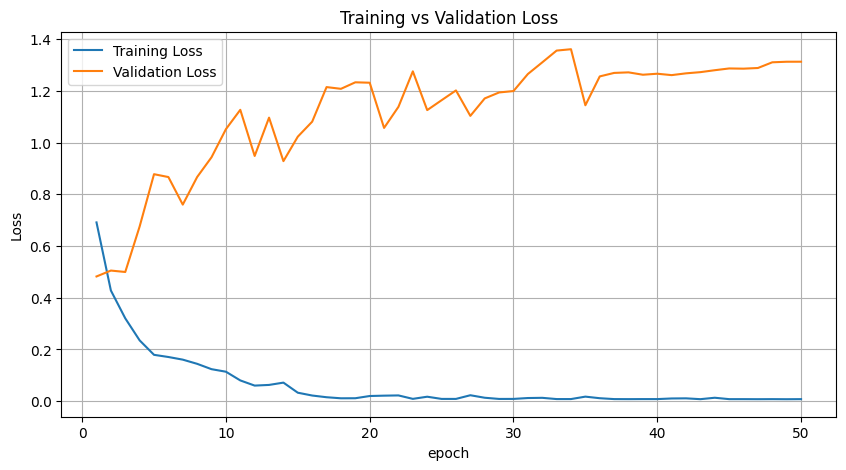

In [ ]:
# Filter hanya entry yang punya eval_loss
df_eval = df_log[df_log['eval_loss'].notna()]
df_train = df_log[df_log['loss'].notna()]

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(df_train['epoch'], df_train['loss'], label='Training Loss')
plt.plot(df_eval['epoch'], df_eval['eval_loss'], label='Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
results = trainer.evaluate(test_dataset)
print("Hasil Evaluasi pada Data Uji:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

Hasil Evaluasi pada Data Uji:
eval_loss: 1.1488
eval_accuracy: 0.8649
eval_precision: 0.8646
eval_recall: 0.8649
eval_f1: 0.8647
eval_runtime: 4.4587
eval_samples_per_second: 107.8800
eval_steps_per_second: 13.6810
epoch: 50.0000


Classification Report:
              precision    recall  f1-score   support

           0     0.7778    0.7568    0.7671        37
           1     0.8926    0.8959    0.8942       269
           2     0.8400    0.8400    0.8400       175

    accuracy                         0.8649       481
   macro avg     0.8368    0.8309    0.8338       481
weighted avg     0.8646    0.8649    0.8647       481



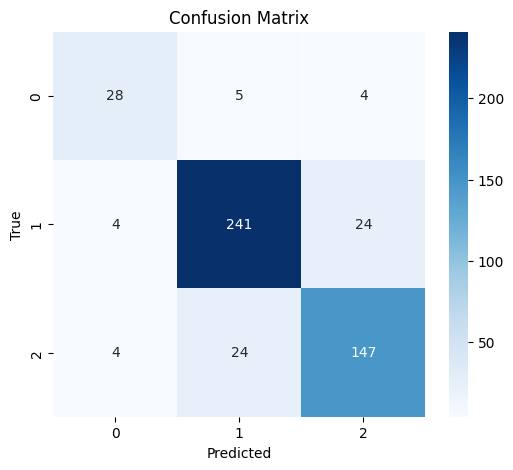

In [ ]:
# Prediksi
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = sorted(list(set(y_true)))  # Ambil label unik

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# SVM Model

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

df_final['clean_text'] = df_final['clean_text'].fillna('')

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X = tfidf_vectorizer.fit_transform(df_final['clean_text'])

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(df_final['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize the SVM model
svc_base = SVC(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(svc_base, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)

# Train the SVM model using GridSearchCV
grid_search.fit(X_train, y_train)

print("GridSearchCV completed successfully.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")

# Assign the best estimator to svm_model
svm_model = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
GridSearchCV completed successfully.
Best parameters found: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation F1-score: 0.7934


In [9]:
import pandas as pd

# Convert cv_results_ to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Select relevant columns for display
display_columns = [
    'param_C',
    'param_gamma',
    'param_kernel',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

# Display the results, sorted by rank
display(results_df[display_columns].sort_values(by='rank_test_score'))

,param_C,param_gamma,param_kernel,mean_test_score,std_test_score,rank_test_score
6,1.0,auto,linear,0.793404,0.031239,1
4,1.0,scale,linear,0.793404,0.031239,1
10,10.0,auto,linear,0.782584,0.035716,3
8,10.0,scale,linear,0.782584,0.035716,3
9,10.0,scale,rbf,0.781788,0.034286,5
13,100.0,scale,rbf,0.781295,0.037352,6
12,100.0,scale,linear,0.776189,0.027313,7
14,100.0,auto,linear,0.776189,0.027313,7
5,1.0,scale,rbf,0.772567,0.033898,9
0,0.1,scale,linear,0.624885,0.017571,10


## Evaluate SVM Classifier

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Generate and print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

     negatif       0.77      0.54      0.63        37
      netral       0.83      0.90      0.86       269
     positif       0.84      0.79      0.81       175

    accuracy                           0.83       481
   macro avg       0.81      0.74      0.77       481
weighted avg       0.83      0.83      0.83       481

Confusion Matrix:
[[ 20  15   2]
 [  3 241  25]
 [  3  34 138]]


In [11]:
import joblib

# Simpan 3 komponen penting
print("Menyimpan model...")
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

print("✅ Berhasil disimpan! Silakan download 3 file .pkl tersebut.")

Menyimpan model...
✅ Berhasil disimpan! Silakan download 3 file .pkl tersebut.


# Lazy Predict

In [ ]:
!pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.9 MB/s eta 0:00:00


In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# Ensure X and y are available from previous steps
df_final['clean_text'] = df_final['clean_text'].fillna('')

# Initialize TfidfVectorizer
tfidf_vectorizer_lp = TfidfVectorizer(max_features=5000)

# Fit and transform the 'clean_text' column to get TF-IDF features (X_lp)
X_lp = tfidf_vectorizer_lp.fit_transform(df_final['clean_text'])

# Initialize LabelEncoder
label_encoder_lp = LabelEncoder()

# Fit and transform the 'label' column to get numerical labels (y_lp)
y_lp = label_encoder_lp.fit_transform(df_final['label'])

# Split the data into training and testing sets for LazyPredict
X_train_lp, X_test_lp, y_train_lp, y_test_lp = train_test_split(X_lp, y_lp, test_size=0.2, random_state=42)

print("Data preparation for LazyPredict complete.")


Data preparation for LazyPredict complete.


In [ ]:
import pandas as pd

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Convert csr_matrix to dense array, then to DataFrame
X_train_lp_df = pd.DataFrame(X_train_lp.toarray())
X_test_lp_df = pd.DataFrame(X_test_lp.toarray())

models, predictions = clf.fit(X_train_lp_df, X_test_lp_df, y_train_lp, y_test_lp)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9052
[LightGBM] [Info] Number of data points in the train set: 1920, number of used features: 333
[LightGBM] [Info] Start training from score -2.542801
[LightGBM] [Info] Start training from score -0.606396
[LightGBM] [Info] Start training from score -0.978055
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
Perceptron                         0.79               0.78    None      0.79   
PassiveAggressiveClassifier        0.78               0.74    None      0.78   
LinearSVC                          0.74               0.73    None      0.75   
XGBClassifier                      0.81               0.73    None      0.81   
Neare